In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 

In [32]:
# Read the CSV with two header rows
lifting_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vS9zh4VbXElt5i2a1QZ1Ty19zILKOEynhrJ_V61r0Okae0qVDeETHWRNtkbuM0EjVUXUtiK6MSquVux/pub?gid=0&single=true&output=tsv'
data = pd.read_csv(lifting_url, header=None, sep='\t')

# Forward-fill the first row to replace the NaN values
data.iloc[0] = data.iloc[0].fillna(method='ffill')

# Replace remaining NaNs in first two rows with an empty string
data.iloc[0] = data.iloc[0].fillna('')
data.iloc[1] = data.iloc[1].fillna('')

# Set the first and second rows as column headers
data.columns = [(x, y) for x, y in zip(data.iloc[0], data.iloc[1])]

# Drop the first two rows as they've been used for headers
data = data.drop([0, 1])

# Ensure 'Date' column values are correctly filled down
data[('Date', '')] = data[('Date', '')].fillna(method='ffill')

# Convert 'Date' column to datetime and set as index
data[('Date', '')] = pd.to_datetime(data[('Date', '')], errors='coerce')
data = data.set_index(('Date', ''))

# Clean up column names to remove tuple formatting for easier access
data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data.columns]
data.columns = [x.replace('_', '') if x[0] == '_' else x for x in data.columns]
data.columns = [x.replace('_', '') if x[-1] == '_' else x for x in data.columns]

# Remove index name to match requirement
data.index.name = None

print(data.head())

           Squat_Weight Squat_Reps Squat_Sets Bench_Weight Bench_Reps  \
2024-10-24           95          5          1          NaN        NaN   
2024-10-24          135          5          1          NaN        NaN   
2024-10-24          155          5          1          NaN        NaN   
2024-10-24          185          5          4          NaN        NaN   
2024-10-22          NaN        NaN        NaN          NaN        NaN   

           Bench_Sets Deadlift_Weight Deadlift_Reps Deadlift_Sets  \
2024-10-24        NaN             NaN           NaN           NaN   
2024-10-24        NaN             NaN           NaN           NaN   
2024-10-24        NaN             NaN           NaN           NaN   
2024-10-24        NaN             NaN           NaN           NaN   
2024-10-22        NaN             135             5             1   

                    Notes  
2024-10-24  Meet recovery  
2024-10-24            NaN  
2024-10-24            NaN  
2024-10-24            NaN  
2024-1

In [39]:
body_comp_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vS9zh4VbXElt5i2a1QZ1Ty19zILKOEynhrJ_V61r0Okae0qVDeETHWRNtkbuM0EjVUXUtiK6MSquVux/pub?gid=1743601009&single=true&output=tsv'
body_comp = pd.read_csv(body_comp_url, sep='\t')

body_comp['Date'] = pd.to_datetime(body_comp['Date'])
body_comp = body_comp.set_index('Date')
body_comp.index.name = None

In [40]:
# Create a squat dataframe by selecting all columns where the first element of each column header tuple is 'Squat'
def parse_lift(data, lift_type='Squat'):
    lift_data = data[[col for col in data.columns if lift_type in col]]
    lift_data = lift_data.dropna()
    lift_data = lift_data.apply(pd.to_numeric)
    lift_data['Marker Size'] = lift_data[lift_type + '_Reps'].astype(int) * lift_data[lift_type + '_Sets'].astype(int) * 5
    lift_data['Date'] = lift_data.index
    return lift_data

squat_data = parse_lift(data, 'Squat')
bench_data = parse_lift(data, 'Bench')
deadlift_data = parse_lift(data, 'Deadlift')

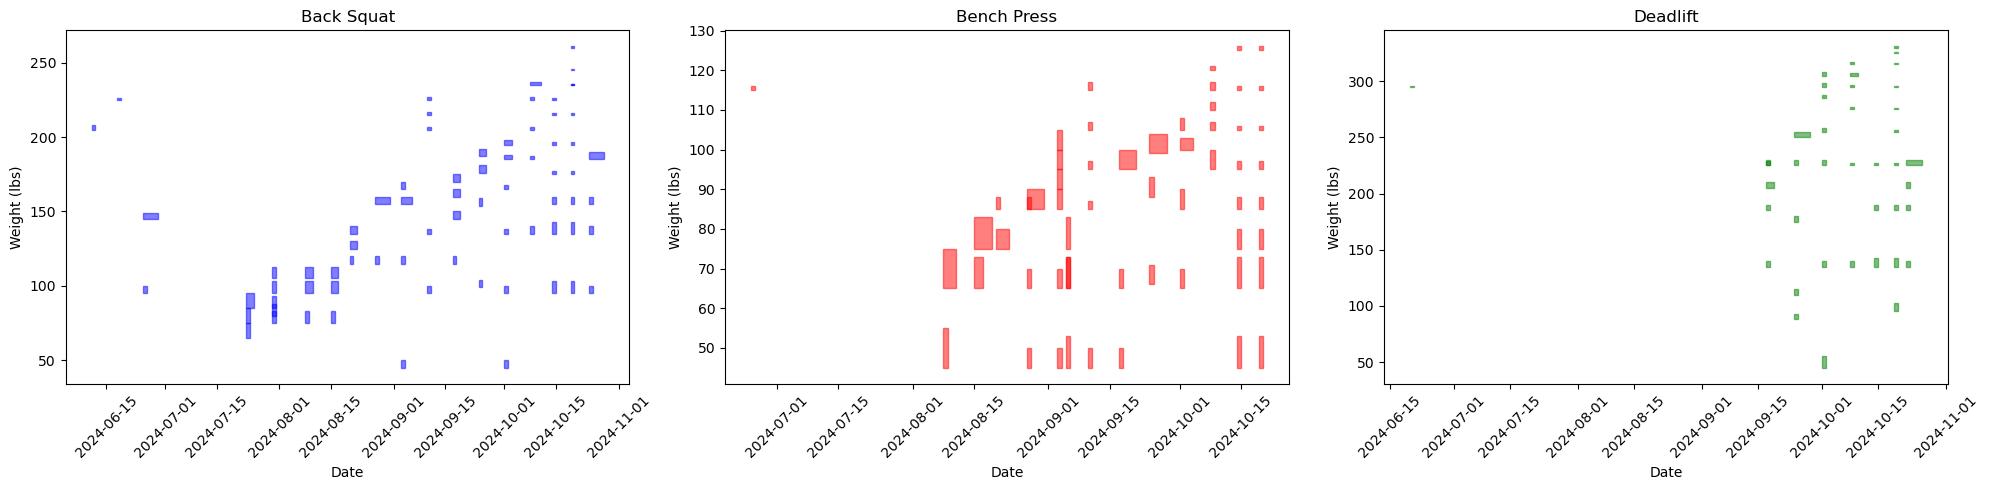

In [41]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates

# Make 3,1 subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Set y-axis range from 0 to weight max + 30
y_offset = 60
axs[0].set_ylim(0, squat_data['Squat_Weight'].max() + y_offset)
axs[1].set_ylim(0, bench_data['Bench_Weight'].max() + y_offset)
axs[2].set_ylim(0, deadlift_data['Deadlift_Weight'].max() + y_offset)

# Function to plot rectangles with correct handling of dates
def plot_rectangles(ax, data, weight_col, date_col, reps_col, sets_col, color, label):
    for _, row in data.iterrows():
        date_num = mdates.date2num(row[date_col])  # Convert datetime to numerical format
        rect = Rectangle(
            (date_num, row[weight_col]),   # Bottom-left corner (date, weight)
            width=row[sets_col],           # Width (scaled by number of sets)
            height=row[reps_col],          # Height (scaled by number of reps)
            color=color, alpha=0.5, label=label
        )
        ax.add_patch(rect)
    ax.autoscale()  # Ensure the axes scale properly to fit the rectangles

# Plot the squat data
plot_rectangles(axs[0], squat_data, 'Squat_Weight', 'Date', 'Squat_Reps', 'Squat_Sets', color='blue', label='Squat')
axs[0].set_title('Back Squat')
axs[0].set_ylabel('Weight (lbs)')
axs[0].set_xlabel('Date')

# Plot the bench data
plot_rectangles(axs[1], bench_data, 'Bench_Weight', 'Date', 'Bench_Reps', 'Bench_Sets', color='red', label='Bench')
axs[1].set_title('Bench Press')
axs[1].set_ylabel('Weight (lbs)')
axs[1].set_xlabel('Date')

# Plot the deadlift data
plot_rectangles(axs[2], deadlift_data, 'Deadlift_Weight', 'Date', 'Deadlift_Reps', 'Deadlift_Sets', color='green', label='Deadlift')
axs[2].set_title('Deadlift')
axs[2].set_ylabel('Weight (lbs)')
axs[2].set_xlabel('Date')

# Change the x-axis labels to be more readable
for ax in axs:
    ax.xaxis_date()  # Inform matplotlib that the x-axis contains dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format dates
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()


In [42]:
body_comp

,Time,Weight (lb),SMM (lb),PBF (%),Total Body Water (lb),Dry Lean Mass (lb),Body Fat Mass (lb),Lean Body Mass (lb),Basal Metabolic Rate (kcal),SMI (kg/m^2),Equipment,Location,Notes
2024-10-23,7:42,200.3,71.2,37.3,91.7,34.0,74.7,125.700000,1601.0,8.2,Inbody 270,"California, USA",Post meet
2024-09-23,13:50,199.5,74.5,33.8,96.6,NaN,67.5,132.056895,1664.0,8.4,Inbody 270,"Beijing, CN",Not fasted
2024-09-03,7:32,193.2,69.4,36.6,89.5,33.1,70.6,122.600000,1571.0,8.0,Inbody 270,"California, USA",NaN
2024-06-19,NaN,193.3,65.3,40.3,NaN,NaN,NaN,NaN,NaN,NaN,Inbody 270,"California, USA",NaN
2024-05-01,NaN,197.7,67.5,39.7,NaN,NaN,NaN,NaN,NaN,NaN,Inbody 270,"California, USA",NaN
2024-04-03,8:15,201.5,67.0,41.0,86.6,32.2,82.7,118.800000,1535.0,7.9,Inbody 270,"California, USA",NaN


Total change in Weight (lb): -1.20
Total change in Lean Body Mass (lb): 6.90
Total change in Body Fat Mass (lb): -8.00
Total change in PBF (%): -3.70


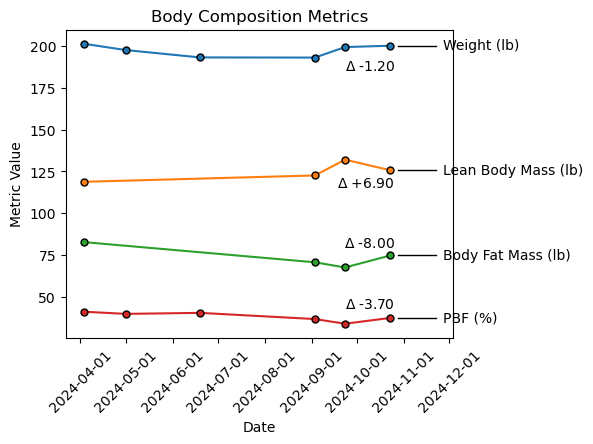

In [128]:
# Plot each metric as its own line and set the labels
fig, ax = plt.subplots(figsize=(5, 4))  # Slightly wider for better spacing with legend

for metric in ['Weight (lb)', 'Lean Body Mass (lb)', 'Body Fat Mass (lb)', 'PBF (%)']:
    # Remove data points where the metric is NaN or invalid
    metric_data = body_comp[metric].dropna()
    if metric_data.empty:
        continue  # Skip plotting if no valid data for the metric

    # Plot the line
    ax.plot(metric_data.index, metric_data, label=metric)
    
    # Add markers at each measured point
    ax.plot(
        metric_data.index, metric_data, 'o',
        color=ax.get_lines()[-1].get_color(), markersize=5, markeredgecolor='black'
    )

ax.set_title('Body Composition Metrics')
ax.set_ylabel('Metric Value')
ax.set_xlabel('Date')

# Rotate x-axis labels for readability
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
for label in ax.get_xticklabels():
    label.set_rotation(45)

# For each metric, add text for total change in value over the time period
for metric in ['Weight (lb)', 'Lean Body Mass (lb)', 'Body Fat Mass (lb)', 'PBF (%)']:
    metric_data = body_comp[metric].dropna()
    if metric_data.empty:
        continue  # Skip if no data for the metric
    
    # Calculate total change
    total_change = metric_data.iloc[0] - metric_data.iloc[-1]
    print(f'Total change in {metric}: {total_change:.2f}')

    # Adjust x and y offsets based on the metric
    x_offset = pd.Timedelta(days=33)  # Increase horizontal spacing to 30 days

    # Larger vertical offset for PBF and other lower-value metrics
    if metric == 'PBF (%)':
        y_offset = -0.1 * (metric_data.max() - metric_data.min())  + 5
    elif metric == 'Weight (lb)':
        y_offset = (0.05 * (metric_data.max() - metric_data.min())) - 14
    else:
        y_offset = -0.05 * (metric_data.max() - metric_data.min())

    ax.text(
        metric_data.index[1] + x_offset,  # Shifted x-position with timedelta
        metric_data.iloc[-1] + y_offset,  # Shifted y-position for downward spacing
        f'$\Delta$ {total_change:+.2f}',  # Text with formatted Δ and value
        ha='right',  # Horizontal alignment
        va='center'  # Vertical alignment
    )

# For each metric, add an arrow and label for the final point
for metric in ['Weight (lb)', 'Lean Body Mass (lb)', 'Body Fat Mass (lb)', 'PBF (%)']:
    metric_data = body_comp[metric].dropna()
    if metric_data.empty:
        continue  # Skip if no data for the metric

    # Get the final point coordinates
    x_final = metric_data.index[1]
    y_final = metric_data.iloc[0]

    # Add a line from the last data point to the label
    ax.plot(
        [x_final + pd.Timedelta(days=35), x_final + pd.Timedelta(days=60)],  # x-coordinates for the line
        [y_final, y_final],  # y-coordinates for the line (horizontal)
        color='black', linewidth=1  # Black line, 3 pixels thick
    )
    
    # Add the label near the last point
    ax.text(
        x_final + pd.Timedelta(days=65),  # Position the label to the right of the line
        y_final,  # Align with the y-coordinate of the line
        metric,  # The metric name as the label
        fontsize=10,
        color=ax.get_lines()[-1].get_color(),  # Match the label color to the line color
        ha='left',  # Horizontal alignment
        va='center'  # Vertical alignment
    )

plt.show()


In [129]:
def daily_max_weight(data, lift_type='Squat', rep_filter=3):

    # Step 1: For each date, find the index of the row with the maximum weight
    idx_max_weight = data.groupby('Date')[f'{lift_type}_Weight'].transform(max) == data[f'{lift_type}_Weight']

    # Step 2: Use this boolean condition to filter the original dataframe for only rows with max weight
    data_daily_max = data[idx_max_weight]

    # Filter for <= 3 reps
    data_daily_max = data_daily_max[data_daily_max[f'{lift_type}_Reps'] <= rep_filter]

    # Predict 1RM using modified Epley formula
    data_daily_max[lift_type + '_1RM_pred'] = data_daily_max[f'{lift_type}_Weight'] * (1 + data_daily_max[f'{lift_type}_Reps'] * data_daily_max[f'{lift_type}_Sets'] / 30)

    return data_daily_max

squat_daily_max = daily_max_weight(squat_data, 'Squat')
bench_daily_max = daily_max_weight(bench_data, 'Bench')
deadlift_daily_max = daily_max_weight(deadlift_data, 'Deadlift')

Predicting 1RM for:
	Squat: 325 lbs
	Bench: 142 lbs
	Deadlift: 405 lbs
	Total: 872 lbs


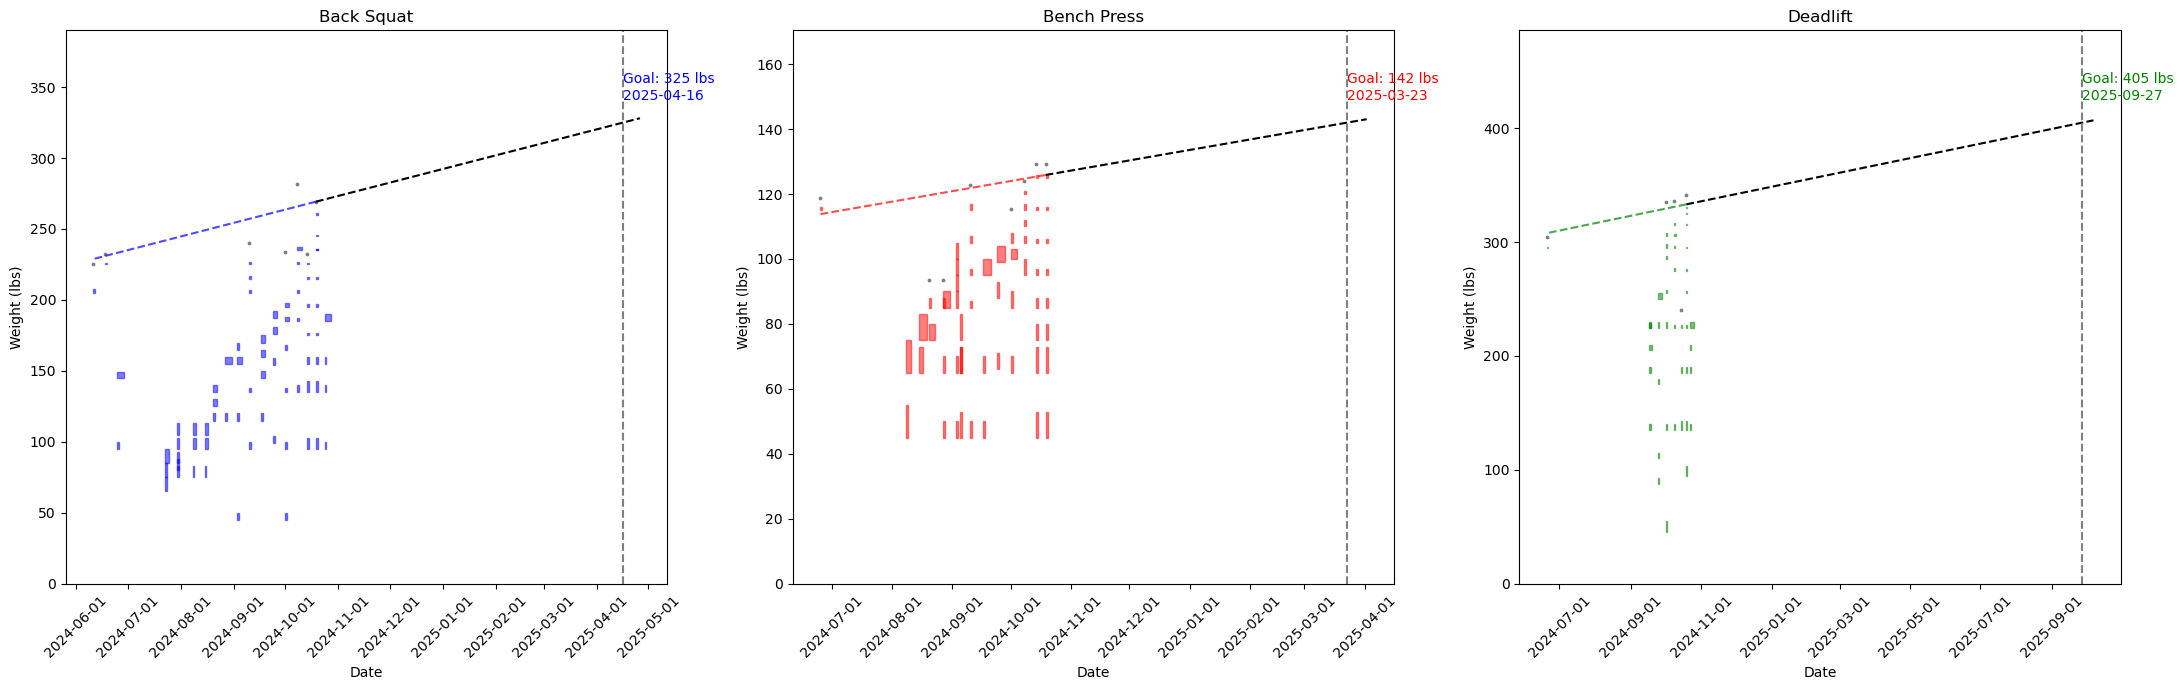

In [130]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
import numpy as np

# Goals for each lift
squat_goal = 325
bench_goal = 142
deadlift_goal = 405

print('Predicting 1RM for:')
print(f'\tSquat: {squat_goal} lbs')
print(f'\tBench: {bench_goal} lbs')
print(f'\tDeadlift: {deadlift_goal} lbs')
print(f'\tTotal: {squat_goal + bench_goal + deadlift_goal} lbs')

# Make 3,1 subplots
fig, axs = plt.subplots(1, 3, figsize=(22, 7))

# Function to plot rectangles with correct handling of dates
def plot_rectangles(ax, data, weight_col, date_col, reps_col, sets_col, color, label):
    for _, row in data.iterrows():
        date_num = mdates.date2num(row[date_col])  # Convert datetime to numerical format
        rect = Rectangle(
            (date_num, row[weight_col]),   # Bottom-left corner (date, weight)
            width=row[sets_col],           # Width (scaled by number of sets)
            height=row[reps_col],          # Height (scaled by number of reps)
            color=color, alpha=0.5, label=label
        )
        ax.add_patch(rect)
    ax.autoscale()  # Ensure the axes scale properly to fit the rectangles

# Function to perform weighted linear regression and extrapolate to the target goal
def pred_1rm(ax, data, lift_type, color, goal_weight):
    # Prepare X and y
    X = (data.index - data.index.min()).days.values.reshape(-1, 1)
    y = data[lift_type + '_1RM_pred'].values

    # Perform initial linear regression
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    # Calculate residuals (difference between actual and predicted values)
    residuals = y - y_pred

    # Assign weights - more weight to points where residual is positive (i.e., y > y_pred)
    weights = np.where(residuals > 0, 5.0, 1.0)  # Give higher weight to points above the line

    # Perform weighted linear regression
    model_weighted = LinearRegression()
    model_weighted.fit(X, y, sample_weight=weights)
    y_pred_weighted = model_weighted.predict(X)

    # Plot the weighted regression line
    ax.plot(data.index, y_pred_weighted, color=color, linestyle='dashed', alpha=0.7, label='Biased Trendline')

    # Plot daily 1RM predictions as points
    ax.scatter(data.index, y, color='gray', label='Predicted 1RM', s=3)

    # Extrapolate the regression to the goal weight
    slope = model_weighted.coef_[0]
    intercept = model_weighted.intercept_

    # Calculate the number of days required to reach the goal weight
    days_to_goal = (goal_weight - intercept) / slope
    goal_date = data.index.min() + np.timedelta64(int(days_to_goal), 'D')

    # Plot the extrapolated regression line (dashed black)
    future_dates = np.arange(X.max(), days_to_goal+10).reshape(-1, 1)
    y_future = model_weighted.predict(future_dates)
    ax.plot(mdates.num2date(mdates.date2num(data.index.min()) + future_dates.flatten()), y_future, color='black', linestyle='dashed')

    # Plot the vertical line at the goal date
    ax.axvline(goal_date, color='grey', linestyle='dashed', label=f'{lift_type} Goal ({goal_weight} lbs)')

    # Annotate the goal date
    ax.annotate(f'Goal: {goal_weight} lbs\n{str(goal_date)[:10]}',  # Convert goal_date to string and extract date
                xy=(goal_date, goal_weight), xytext=(goal_date, goal_weight *1.05),
                fontsize=10, color=color)

    y_offset = 1.2
    ax.set_ylim(0, goal_weight * y_offset)


# Plot the squat data
plot_rectangles(axs[0], squat_data, 'Squat_Weight', 'Date', 'Squat_Reps', 'Squat_Sets', color='blue', label='Squat')
pred_1rm(axs[0], squat_daily_max, 'Squat', 'blue', squat_goal)
axs[0].set_title('Back Squat')
axs[0].set_ylabel('Weight (lbs)')
axs[0].set_xlabel('Date')

# Plot the bench data
plot_rectangles(axs[1], bench_data, 'Bench_Weight', 'Date', 'Bench_Reps', 'Bench_Sets', color='red', label='Bench')
pred_1rm(axs[1], bench_daily_max, 'Bench', 'red', bench_goal)
axs[1].set_title('Bench Press')
axs[1].set_ylabel('Weight (lbs)')
axs[1].set_xlabel('Date')

# Plot the deadlift data
plot_rectangles(axs[2], deadlift_data, 'Deadlift_Weight', 'Date', 'Deadlift_Reps', 'Deadlift_Sets', color='green', label='Deadlift')
pred_1rm(axs[2], deadlift_daily_max, 'Deadlift', 'green', deadlift_goal)
axs[2].set_title('Deadlift')
axs[2].set_ylabel('Weight (lbs)')
axs[2].set_xlabel('Date')

# Change the x-axis labels to be more readable
for ax in axs:
    ax.xaxis_date()  # Inform matplotlib that the x-axis contains dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format dates
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()
